In [48]:
from src.Base.Evaluation.Evaluator import EvaluatorHoldout
import numpy as np
from src.Utils.load_ICM import load_ICM
from src.Utils.load_URM import load_URM

import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)

URM_all = load_URM("in/data_train.csv")
ICM_all = load_ICM("in/data_ICM_title_abstract.csv")

from src.Data_manager.split_functions.split_train_validation_random_holdout import split_train_in_two_percentage_global_sample

URM_train, URM_test = split_train_in_two_percentage_global_sample(URM_all, train_percentage=0.80)

In [49]:
from src.Utils.ICM_preprocessing import *
from src.GraphBased.P3alphaRecommender import P3alphaRecommender
from src.GraphBased.RP3betaCBFRecommender import RP3betaCBFRecommender
from src.Hybrid.SimilarityMergedHybridRecommender import SimilarityMergedHybridRecommender
from src.Base.NonPersonalizedRecommender import TopPop
from src.MatrixFactorization.PureSVDRecommender import PureSVDItemRecommender
ICM_combined = combine(ICM=ICM_all, URM = URM_train)

p3alpha_recommender = P3alphaRecommender(URM_train=URM_train)
p3alpha_recommender.fit(topK=221,alpha=0.5017,implicit=True)

rp3betaCBF_recommender = RP3betaCBFRecommender(URM_train=URM_train, ICM_train=ICM_combined)
rp3betaCBF_recommender.fit(topK=586, alpha=0.4228, beta=0.1918, implicit=False)

p3alpha_featurecombinedrp3beta_recommender = SimilarityMergedHybridRecommender(
    URM_train=URM_train,
    CFRecommender=p3alpha_recommender,
    CBFRecommender=rp3betaCBF_recommender
)
p3alpha_featurecombinedrp3beta_recommender.fit(topK=355, alpha=0.2222)

pureSVDitem_recommender = PureSVDItemRecommender(URM_train)
pureSVDitem_recommender.fit(num_factors=448,topK=462)

topPop = TopPop(URM_train)
topPop.fit()

P3alphaRecommender: URM Detected 61 (0.77 %) cold users.
P3alphaRecommender: URM Detected 2447 (9.42 %) cold items.
RP3betaCBFRecommender: URM Detected 61 (0.77 %) cold users.
RP3betaCBFRecommender: URM Detected 2447 (9.42 %) cold items.
RP3betaRecommender: URM Detected 63 (0.23 %) cold users.
P3alphaRP3betaCBFHybridRecommender: URM Detected 61 (0.77 %) cold users.
P3alphaRP3betaCBFHybridRecommender: URM Detected 2447 (9.42 %) cold items.
PureSVDItemRecommender: URM Detected 61 (0.77 %) cold users.
PureSVDItemRecommender: URM Detected 2447 (9.42 %) cold items.
PureSVDItemRecommender: Computing SVD decomposition...
PureSVDItemRecommender: Computing SVD decomposition... Done!
TopPopRecommender: URM Detected 61 (0.77 %) cold users.
TopPopRecommender: URM Detected 2447 (9.42 %) cold items.


In [50]:
profile_length = np.ediff1d(URM_train.indptr)
block_size = int(len(profile_length)*0.1)
sorted_users = np.argsort(profile_length)


In [51]:
for group_id in range(0, 10):

    start_pos = group_id*block_size
    end_pos = min((group_id+1)*block_size, len(profile_length))

    users_in_group = sorted_users[start_pos:end_pos]

    users_in_group_p_len = profile_length[users_in_group]

    print("Group {}, average p.len {:.2f}, min {}, max {}".format(group_id,
        users_in_group_p_len.mean(), users_in_group_p_len.min(), users_in_group_p_len.max()))

Group 0, average p.len 1.16, min 0, max 2
Group 1, average p.len 2.00, min 2, max 2
Group 2, average p.len 2.68, min 2, max 3
Group 3, average p.len 3.21, min 3, max 4
Group 4, average p.len 4.15, min 4, max 5
Group 5, average p.len 5.39, min 5, max 6
Group 6, average p.len 6.95, min 6, max 8
Group 7, average p.len 9.66, min 8, max 12
Group 8, average p.len 16.28, min 12, max 22
Group 9, average p.len 56.31, min 22, max 433


In [52]:
MAP_hybrid_per_group = []
MAP_p3alpha_per_group = []
MAP_featurecombinationRP3beta_per_group = []
MAP_pureSVDitem_per_group = []
MAP_topPop_per_group = []
cutoff = 10

for group_id in range(0, 10):

    start_pos = group_id*block_size
    end_pos = min((group_id+1)*block_size, len(profile_length))

    users_in_group = sorted_users[start_pos:end_pos]

    users_in_group_p_len = profile_length[users_in_group]

    print("Group {}, average p.len {:.2f}, min {}, max {}".format(group_id,
        users_in_group_p_len.mean(), users_in_group_p_len.min(), users_in_group_p_len.max()))


    users_not_in_group_flag = np.isin(sorted_users, users_in_group, invert = True)
    users_not_in_group = sorted_users[users_not_in_group_flag]

    evaluator_test = EvaluatorHoldout(URM_test, cutoff_list=[cutoff], ignore_users = users_not_in_group)


    results, _ = evaluator_test.evaluateRecommender(p3alpha_featurecombinedrp3beta_recommender)
    MAP_hybrid_per_group.append(results[cutoff]["MAP"])

    results, _ = evaluator_test.evaluateRecommender(p3alpha_recommender)
    MAP_p3alpha_per_group.append(results[cutoff]["MAP"])

    results, _ = evaluator_test.evaluateRecommender(rp3betaCBF_recommender)
    MAP_featurecombinationRP3beta_per_group.append(results[cutoff]["MAP"])

    results, _ = evaluator_test.evaluateRecommender(pureSVDitem_recommender)
    MAP_pureSVDitem_per_group.append(results[cutoff]["MAP"])

    results, _ = evaluator_test.evaluateRecommender(topPop)
    MAP_topPop_per_group.append(results[cutoff]["MAP"])



Group 0, average p.len 1.16, min 0, max 2
EvaluatorHoldout: Ignoring 7153 Users
EvaluatorHoldout: Processed 632 ( 100.00% ) in 0.41 sec. Users per second: 1540
EvaluatorHoldout: Processed 632 ( 100.00% ) in 0.38 sec. Users per second: 1644
EvaluatorHoldout: Processed 632 ( 100.00% ) in 0.38 sec. Users per second: 1662
EvaluatorHoldout: Processed 632 ( 100.00% ) in 0.39 sec. Users per second: 1619
EvaluatorHoldout: Processed 632 ( 100.00% ) in 0.51 sec. Users per second: 1229
Group 1, average p.len 2.00, min 2, max 2
EvaluatorHoldout: Ignoring 7153 Users
EvaluatorHoldout: Processed 392 ( 100.00% ) in 0.25 sec. Users per second: 1599
EvaluatorHoldout: Processed 392 ( 100.00% ) in 0.23 sec. Users per second: 1741
EvaluatorHoldout: Processed 392 ( 100.00% ) in 0.25 sec. Users per second: 1592
EvaluatorHoldout: Processed 392 ( 100.00% ) in 0.27 sec. Users per second: 1467
EvaluatorHoldout: Processed 392 ( 100.00% ) in 0.30 sec. Users per second: 1319
Group 2, average p.len 2.68, min 2, max 

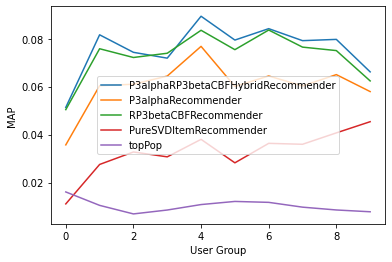

In [53]:
import matplotlib.pyplot as pyplot
%matplotlib inline

pyplot.plot(MAP_hybrid_per_group, label=p3alpha_featurecombinedrp3beta_recommender.RECOMMENDER_NAME)
pyplot.plot(MAP_p3alpha_per_group, label=p3alpha_recommender.RECOMMENDER_NAME)
pyplot.plot(MAP_featurecombinationRP3beta_per_group, label=RP3betaCBFRecommender.RECOMMENDER_NAME)
pyplot.plot(MAP_pureSVDitem_per_group, label=pureSVDitem_recommender.RECOMMENDER_NAME)
pyplot.plot(MAP_topPop_per_group, label="topPop")
pyplot.ylabel('MAP')
pyplot.xlabel('User Group')
pyplot.legend()
pyplot.show()


